# Résolution - un seul véhicule
## I - Définition des données et des fonctions communes aux différentes méthodes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import optimize

In [2]:
#données du problème :

n=100#discretisation

#temps:
t0=0
tf=299
lt=np.linspace(t0,tf,n+1)

#charge
Qm=60
c0=0.2
cf=1

#prix
ph=1
pb=0.5

#Intensité
Im=1

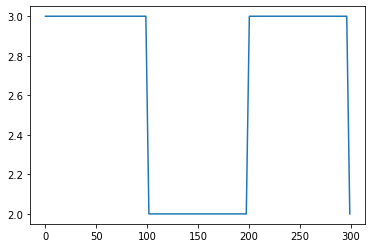

In [3]:
def PrixHoraire(t,ph,pb):
    n=np.floor(t)
    if n%200 < 99:
        return ph
    else:
        return pb
    
VPrixHoraire= np.vectorize(PrixHoraire)
lprix=VPrixHoraire(lt,3,2)
plt.plot(lt,lprix)
plt.show()

In [4]:
def charge(I): #donne la charge à tout temps(charge absolue, pas en %)
    c=c0*Qm
    charge=np.zeros(n)
    for i in range (n):
        Q=-(lt[i+1]-lt[i])*(I[i])
        c+=Q
        charge[i]=c
    return charge

In [5]:
def fcout1(I): 
    S=0
    listeS=[]
    for i in range (n):
        Q=-(lt[i+1]-lt[i])*I[i]
        P=PrixHoraire(lt[i],ph,pb) #On suppose ici que l'on ne change pas de prix horaire sur l'intervalle listet[i], listet[i+1]
        S+=P*Q
        listeS.append(S)
    return S,np.array(listeS)

In [6]:
def affichage(I):  
    I1=[-100*I[i] for i in range(n)]
    lcout=fcout1(I)[1]
    lcharge=charge(I)
    lprix=VPrixHoraire(lt[0:n],3,2)
    plt.plot(lt[0:n],lcout,'+',label="cout (en euros)")
    plt.plot(lt[0:n],lcharge,'+',label="charge (en A.min)")
    plt.plot(lt[0:n],lprix,'+',label="prix en euros/A/min")
    plt.plot(lt[0:n],I1,'+',label="intensité (en 1e-2 A)")
    plt.legend()
    plt.plot()

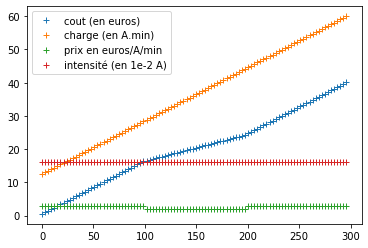

In [7]:
def I0(): #Intensité qui respecte les contraintes mais n'est pas optimale
    res=np.zeros(n)
    for i in range (n):
        res[i]=-Qm*(cf-c0)/(tf-t0)
    return res
affichage(I0())

## II - Construction d'une solution optimale

In [8]:
def algoM():
    E=(cf-c0)*Qm #énergie à fournir
    
    #il faut connaitre le temps disponible en heures creuses/pleines
    Tp=[]
    Tc=[]
    deltaT=lt[1]-lt[0]#pas de temps
    for i in range (len(lt)-1):
        m=np.floor(lt[i])
        if m%200 < 99:
            Tp.append(i)
        else:
            Tc.append(i)
    tp=len(Tp)*deltaT #durée des heures pleines
    tc=len(Tc)*deltaT #durée des heures creuses
    
    I=np.zeros(n)
    
    if (tf-t0)*Im<E:
        return ("le temps de chargement n'est pas suffisant")
    
    elif tc*Im>E: #les heures creuses sont suffisantes 
        Ic=-E/tc
        
        for i in Tc:
            I[i]=Ic
        return I
    
    
    #il faut charger au maximum pendant les heures creuses et compléter par les heures pleines
    Ic=Im
    for i in Tc:
        I[i]=-Ic
    Ec=tc*Im #énergie reçue pendant les heures creuses
    Ip=(E-Ec)/tp
    for i in Tp:
        I[i]=-Ip
    return I

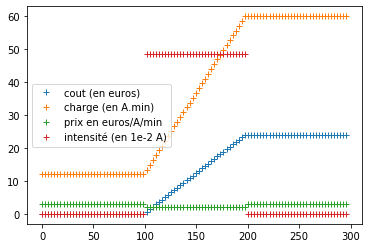

In [9]:
I=algoM()
affichage(I)

## III - Résolution avec Scipy

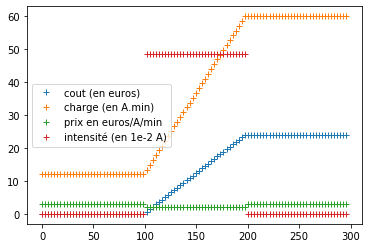

In [10]:
F=np.array([(lt[i+1]-lt[i])*PrixHoraire(lt[i],ph,pb) for i in range (n)])

# Contrainte égalité (chargement)


Aeq=np.zeros ((1,n))
Aeq[0,:]=np.array([lt[i+1]-lt[i] for i in range (n)])
    
Beq=np.zeros(1)
Beq[0]=-(cf-c0)*Qm

X=optimize.linprog(-F,A_ub=None,b_ub=None,A_eq=Aeq,b_eq=Beq,bounds=(-Im,0))

I=X["x"]
affichage(I)


# IV - Résolution par une méthode des points intérieurs (affine scaling)

In [11]:
Tc=[]
for i in range (len(lt)-1):
    m=np.floor(lt[i])
    if not m%200 < 99:
        Tc.append(i)
m=len(Tc) #nombre de contraintes à ajouter


A=np.zeros ((1+m,n+m))
    
# Contrainte égalité (chargement)
A[0][:n]=np.array([lt[i+1]-lt[i] for i in range (n)])
#contraintes inégalites
for i in range (m):
    A[i+1,Tc[i]]=1
    A[i+1,n+i]=1

    
B=np.zeros(1+m)
B[0]=(cf-c0)*Qm
for i in range(m):
    B[i+1]=Im

C=np.zeros(n+m)
for i in range(n):
    C[i]=PrixHoraire(lt[i],ph,pb)*(lt[i+1]-lt[i])

In [12]:
def sup(x):
    for i in range(len(x)):
        if x[i]<0:
            return 0
    return 1

In [13]:
def algoASA(max_iter=10000,epsi=1e-3,beta=0.9):

    xk=-I0()

    k=0
    m=np.shape(A)[0]-1
    Z=np.array([Im-xk[Tc[i]] for i in range (m)])#variables d'écarts
    xk=np.concatenate((xk,Z),axis=0)
    Xk=np.diag(xk)
    e=np.array([1 for i in range(n+m)])
    H1=np.matmul(np.matmul(A,Xk),np.matmul(Xk,np.transpose(A)))
    H2=np.matmul(np.dot(A,Xk),np.dot(Xk,C))
    pk=np.matmul(np.linalg.inv(H1),H2)
    rk=C-np.dot(np.transpose(A),pk)
    while k<max_iter:
        if sup(rk) and np.dot(e,np.dot(Xk,rk))<epsi:
            return xk
        G=np.dot(np.dot(Xk,Xk),rk)
        if sup(-G):
            return ("solution non finie")
        xk=xk-beta*G/np.linalg.norm(np.dot(Xk,rk))
        Xk=np.diag(xk)
        
        H1=np.matmul(np.dot(A,Xk),np.matmul(Xk,np.transpose(A)))
        H2=np.matmul(np.dot(A,Xk),np.matmul(Xk,C))
        pk=np.matmul(np.linalg.inv(H1),H2)
        rk=C-np.dot(np.transpose(A),pk)
        k+=1
        if k%500==0:
            print(k)
    
    return xk

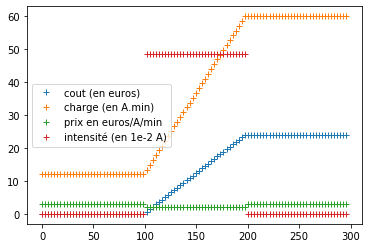

In [14]:
I=-algoASA()
affichage(I)